In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

import sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,\
                            roc_curve, auc, roc_auc_score, f1_score, precision_recall_curve,\
                            precision_score, average_precision_score, recall_score
from sklearn.metrics.scorer import make_scorer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")
import scikitplot 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [3]:
data = pd.read_csv('spam.csv', usecols = [0,1], encoding='latin-1')
data.columns = ['label', 'text']
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [5]:
data['length'] = data.text.str.len()
data['cat'] = data['label'].map({'ham' : 1, 'spam' : 0})
data

,label,text,length,cat
0,ham,"Go until jurong point, crazy.. Available only ...",111,1
1,ham,Ok lar... Joking wif u oni...,29,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,0
3,ham,U dun say so early hor... U c already then say...,49,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148,0
6,ham,Even my brother is not like to speak with me. ...,77,1
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,1
8,spam,WINNER!! As a valued network customer you have...,158,0
9,spam,Had your mobile 11 months or more? U R entitle...,154,0


In [6]:
stop_words = set(stopwords.words('english'))

In [7]:
##remove punc and stop
def remove_punc_stop(text):
    sen = [i for i in text if i not in string.punctuation]
    word = "".join(sen).split()
    word = [i.lower() for i in word if i.lower() not in stopwords.words("english")]
    word = " ".join(word)
    return word

def plot_wordcloud(data, type):
    full_text = ''.join(data['cleaned text'][i] for i in range(len(data)) if data.cat[i] == type)
    wordcloud = WordCloud(max_words = 100, background_color="white").generate(full_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title((['spam', 'ham'][type]), fontsize = 20)

def plot_mostfreq(data, type, mostcommon):
    full = word_tokenize(''.join([data['cleaned text'][i] for i in range(len(data)) if data.cat[i] == type]))
    freq = nltk.FreqDist(full)
    freq.plot(mostcommon, title = (['spam', 'ham'][type]))
    
def plot_mostfreq2(data, type, mostcommon):
    full = word_tokenize(''.join([data['cleaned text'][i] for i in range(len(data)) if data.cat[i] == type]))
    freq = nltk.FreqDist(full)
    dataframe = pd.DataFrame(freq.most_common(mostcommon))
    word = dataframe[0]
    count = dataframe[1]
    sns.barplot(x = word[0:mostcommon], y = count[0:mostcommon], data = dataframe)
    plt.xticks(rotation='vertical')
    plt.title(['spam', 'ham'][type])
    

In [8]:
data['cleaned text'] = data.text.apply(remove_punc_stop)

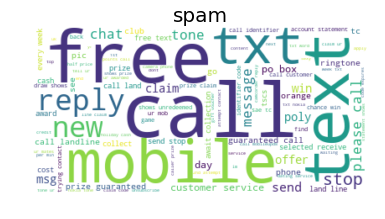

In [9]:
plot_wordcloud(data, 0)

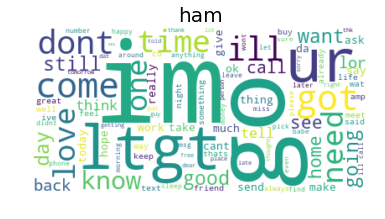

In [10]:
plot_wordcloud(data, 1)

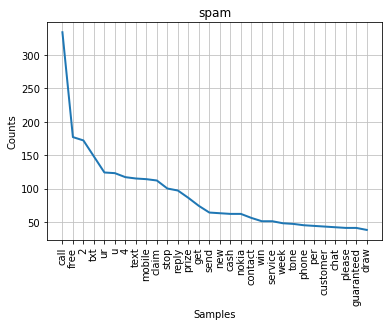

In [11]:
plot_mostfreq(data, 0, 30)

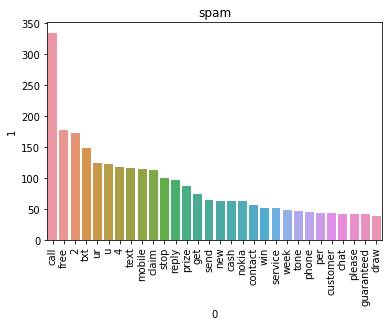

In [12]:
plot_mostfreq2(data, 0, 30)

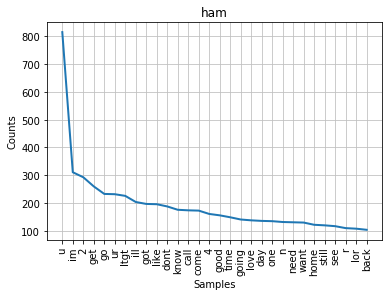

In [13]:
plot_mostfreq(data, 1, 30)

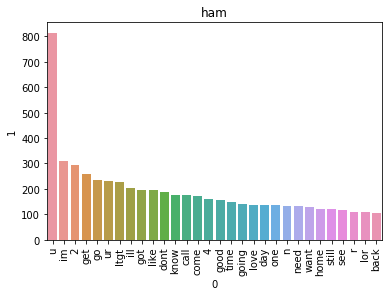

In [14]:
plot_mostfreq2(data, 1, 30)

## Vectorizing

In [10]:
##counting the occurrences of tokens in each document.
vectorizer = CountVectorizer()
data_X = vectorizer.fit_transform(data['cleaned text'])

##To avoid these potential discrepancies it suffices to divide the number of occurrences 
##of each word in a document by the total number of words in the document: 
##these new features are called tf for Term Frequencies.
vectorizer2 = TfidfVectorizer()
data_X2 = vectorizer2.fit_transform(data['cleaned text'])

dictionary = np.array(vectorizer.get_feature_names())
dictionary2 = np.array(vectorizer2.get_feature_names())


In [11]:
##nonzero term in data
print(data_X.nnz)
##% of nonzero term
(data_X.nnz)/(data_X.shape[0]*data_X.shape[1])*100

47254


0.09045027061195789

In [12]:
##nonzero term in data
print(data_X2.nnz)
##% of nonzero term
(data_X2.nnz)/(data_X2.shape[0]*data_X2.shape[1])*100

47254


0.09045027061195789

In [13]:
data_X.shape, data_X2.shape

((5572, 9376), (5572, 9376))

In [14]:
dictionary = np.array(vectorizer.get_feature_names())

In [15]:
vectorizer.transform(data['cleaned text'])

<5572x9376 sparse matrix of type '<class 'numpy.int64'>'
	with 47254 stored elements in Compressed Sparse Row format>

In [16]:
vectorizer2.transform(data['cleaned text'])

<5572x9376 sparse matrix of type '<class 'numpy.float64'>'
	with 47254 stored elements in Compressed Sparse Row format>

## Split data

In [17]:
X_tr, X_te, y_tr, y_te = \
    model_selection.train_test_split(data_X, data.cat, test_size = 0.2, random_state = 1)

In [18]:
X_tr2, X_te2, y_tr2, y_te2 = \
    model_selection.train_test_split(data_X2, data.cat, test_size = 0.2, random_state = 1)

In [19]:
X_tr.shape, X_te.shape, X_tr2.shape, X_te2.shape

((4457, 9376), (1115, 9376), (4457, 9376), (1115, 9376))

## SVC and KNN

In [25]:
##function to tune parameter for each model
# Need to spicify metrics, kernel set, C set to use
def svc_tune_parameter(X, y, metric, kernel_set, C_set, cv):
    S = {}
    for k in kernel_set:
        score = {}
        for c in C_set:
            model = SVC(C = c, kernel = k)
            s = model_selection.cross_validate(model, X, y, scoring = metric, cv = cv)
            score[c] = s
        S[k] = score
    return S

def knn_tune_parameter(X, y, metric, Weight, N_neighbors, cv):
    S = {}
    for w in Weight:
        score = {}
        for n in N_neighbors:
            model = KNeighborsClassifier(n_neighbors = n, weights = w)
            s = model_selection.cross_validate(model, X, y, scoring = metric, cv = cv)
            score[n] = s
        S[w] = score
    return S

##return the mean score for 5-fold cross-validation with given metric
def mean_calculator(metric, kernel, C, S_dict):
    return(np.mean(S_dict[kernel][C][metric]))

##calculate the max score with given metric, crossing kernel and C
def best_parameter(metric, kernel, C, S_dict):
    M = {}
    for k in kernel:
        mid = {}
        for c in C:
            mean = mean_calculator(metric, k, c, S_dict)
            mid[c] = mean
        M[k] = mid
        
    max_c_kernel = {}
    for k in kernel:
        max_c_kernel[k] = max(M[k].items(), key = lambda x: x[1])
    
    
    max_kernel = max(max_c_kernel.items(), key = lambda x: x[1][1])
        
    return (max_kernel, max_c_kernel, M)

### For CountVectorizer

In [26]:
metric = {'Accuracy': make_scorer(accuracy_score), \
                     'precision': make_scorer(precision_score), \
                     'recall': make_scorer(recall_score), \
                     'AUC': make_scorer(roc_auc_score), \
                     'precision-recall curve' : make_scorer(average_precision_score),\
                     'f1' : make_scorer(f1_score)}
kernel_set = ['linear', 'rbf', 'poly', 'sigmoid']
C_set = range(1,6)
s = svc_tune_parameter(X_tr, y_tr, metric, kernel_set, C_set, cv = 5)
metric = 'test_AUC'
compare_result = best_parameter(metric, kernel_set, C_set, s)

In [27]:
compare_result 

(('linear', (1, 0.9219612624840735)),
 {'linear': (1, 0.9219612624840735),
  'rbf': (1, 0.5),
  'poly': (1, 0.5),
  'sigmoid': (1, 0.5)},
 {'linear': {1: 0.9219612624840735,
   2: 0.9203219182217784,
   3: 0.9203219182217784,
   4: 0.9203219182217784,
   5: 0.9203219182217784},
  'rbf': {1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5},
  'poly': {1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5},
  'sigmoid': {1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5}})

In [28]:
metric = {'Accuracy': make_scorer(accuracy_score), \
                     'precision': make_scorer(precision_score), \
                     'recall': make_scorer(recall_score), \
                     'AUC': make_scorer(roc_auc_score), \
                     'precision-recall curve' : make_scorer(average_precision_score),\
                     'f1' : make_scorer(f1_score)}
Weights = ['uniform', 'distance']
N_neighbors = range(5,16)
s2 = knn_tune_parameter(X_tr, y_tr, metric, Weights, N_neighbors, cv = 5)
metric = 'test_AUC'
compare_result2 = best_parameter(metric, Weights, N_neighbors, s2)

In [29]:
compare_result2

(('distance', (5, 0.721169218263108)),
 {'uniform': (6, 0.6463487332339792), 'distance': (5, 0.721169218263108)},
 {'uniform': {5: 0.644709388971684,
   6: 0.6463487332339792,
   7: 0.6085151063541525,
   8: 0.6109808968974394,
   9: 0.5789188456848665,
   10: 0.5805649640970059,
   11: 0.5559206069638261,
   12: 0.5600392900690964,
   13: 0.5304362552499662,
   14: 0.5312559273811137,
   15: 0.5197669692453596},
  'distance': {5: 0.721169218263108,
   6: 0.7080205934155264,
   7: 0.697317436661699,
   8: 0.6923926297249695,
   9: 0.6808833491396831,
   10: 0.6751320959219618,
   11: 0.662816691505216,
   12: 0.6562457661563474,
   13: 0.6455629318520526,
   14: 0.6365194418100529,
   15: 0.6324075328546267}})

### For TfidfVectorizer

In [30]:
metric = {'Accuracy': make_scorer(accuracy_score), \
                     'precision': make_scorer(precision_score), \
                     'recall': make_scorer(recall_score), \
                     'AUC': make_scorer(roc_auc_score), \
                     'precision-recall curve' : make_scorer(average_precision_score),\
                     'f1' : make_scorer(f1_score)}
kernel_set = ['linear', 'rbf', 'poly', 'sigmoid']
C_set = range(1,6)
s3 = svc_tune_parameter(X_tr2, y_tr2, metric, kernel_set, C_set, cv = 5)
metric = 'test_AUC'
compare_result3 = best_parameter(metric, kernel_set, C_set, s3)

In [31]:
compare_result3

(('linear', (2, 0.9221380203520478)),
 {'linear': (2, 0.9221380203520478),
  'rbf': (1, 0.5),
  'poly': (1, 0.5),
  'sigmoid': (1, 0.5)},
 {'linear': {1: 0.909242168067224,
   2: 0.9221380203520478,
   3: 0.9206217720697787,
   4: 0.9217011844606666,
   5: 0.9206149979199345},
  'rbf': {1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5},
  'poly': {1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5},
  'sigmoid': {1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5}})

In [32]:
metric = {'Accuracy': make_scorer(accuracy_score), \
                     'precision': make_scorer(precision_score), \
                     'recall': make_scorer(recall_score), \
                     'AUC': make_scorer(roc_auc_score), \
                     'precision-recall curve' : make_scorer(average_precision_score),\
                     'f1' : make_scorer(f1_score)}
Weights = ['uniform', 'distance']
N_neighbors = range(5,16)
s4 = knn_tune_parameter(X_tr2, y_tr2, metric, Weights, N_neighbors, cv = 5)
metric = 'test_AUC'
compare_result4 = best_parameter(metric, Weights, N_neighbors, s4)

In [33]:
compare_result4

(('distance', (15, 0.7802860626705633)),
 {'uniform': (10, 0.7615296030348191), 'distance': (15, 0.7802860626705633)},
 {'uniform': {5: 0.6077225308223818,
   6: 0.6427491435539127,
   7: 0.6018561170573093,
   8: 0.722944045522287,
   9: 0.6777198211624441,
   10: 0.7615296030348191,
   11: 0.7278214334101071,
   12: 0.7544256488667814,
   13: 0.7291942632628177,
   14: 0.7542686821375346,
   15: 0.7314070876962084},
  'distance': {5: 0.687461048638396,
   6: 0.6874475003387076,
   7: 0.6981100121934698,
   8: 0.7096667118276656,
   9: 0.7327597886465249,
   10: 0.7492074244682293,
   11: 0.7689202005148352,
   12: 0.7754979000135483,
   13: 0.7746714537325565,
   14: 0.7735852671918246,
   15: 0.7802860626705633}})

#### For CountVectorizer(), SVC is linear with c = 1, KNN is distance with n = 5, for TfidfVectorizer(), SVC is lienar with c = 2, KNN is distance with n = 15

In [20]:
M1 = SVC(C = 1, kernel = 'linear',probability=True)
M2 = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
M3 = SVC(C = 2, kernel = 'linear',probability=True)
M4 = KNeighborsClassifier(n_neighbors = 15, weights = 'distance')

In [21]:
def plot_roc(model,y_pred, plot_title, x_tr, y_tr, x_te):
    probas_= model.fit(x_tr, y_tr).predict_proba(x_te)
    print("roc_auc for class 1:", metrics.roc_auc_score(y_pred,probas_[:,1]))
    scikitplot.metrics.plot_roc(y_pred, probas_, 
                            title = plot_title,
                            plot_micro = False, plot_macro = False)
    plt.show()

In [22]:
def plot_precision(model,y_pred, plot_title, x_tr, y_tr,x_te):
    probas_= model.fit(x_tr, y_tr).predict_proba(x_te)
    scikitplot.metrics.plot_precision_recall(y_pred, probas_, 
                                         title = plot_title,
                                         plot_micro = False)
    
                          
    plt.show()
    

#### model = M1, CountVectorizer(), SVC is linear with c = 1

In [23]:
M1.fit(X_tr, y_tr)
pre = M1.predict(X_te)
pd.DataFrame(confusion_matrix(pre, y_te),\
             index = ['Predict spam', 'Predict ham'], \
             columns = ['Actual spam', 'Actual ham'])

,Actual spam,Actual ham
Predict spam,130,0
Predict ham,9,976


In [24]:
print(classification_report(pre, y_te))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       130
           1       1.00      0.99      1.00       985

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.97      1.00      0.98      1115
weighted avg       0.99      0.99      0.99      1115



roc_auc for class 1: 0.9999999999999999


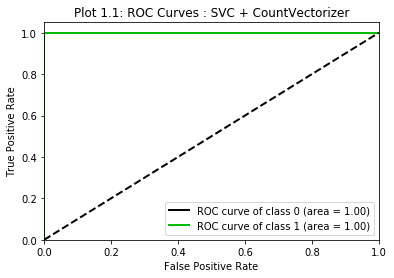

In [25]:
plot_roc(M1,pre, "Plot 1.1: ROC Curves : SVC + CountVectorizer", X_tr,y_tr, X_te)

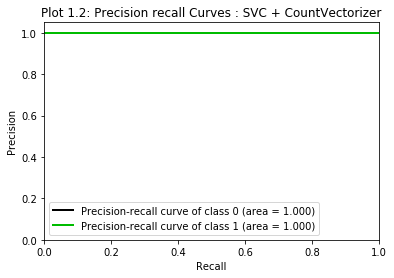

In [26]:
plot_precision(M1,pre, "Plot 1.2: Precision recall Curves : SVC + CountVectorizer",X_tr,y_tr, X_te)

#### model = M2, CountVectorizer(), KNN is distance with n = 5

In [27]:
M2.fit(X_tr, y_tr)
pre2 = M2.predict(X_te)
pd.DataFrame(confusion_matrix(pre2, y_te),\
             index = ['Predict spam', 'Predict ham'], \
             columns = ['Actual spam', 'Actual ham'])

,Actual spam,Actual ham
Predict spam,85,0
Predict ham,54,976


In [28]:
print(classification_report(pre2, y_te))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        85
           1       1.00      0.95      0.97      1030

   micro avg       0.95      0.95      0.95      1115
   macro avg       0.81      0.97      0.87      1115
weighted avg       0.97      0.95      0.96      1115



roc_auc for class 1: 1.0


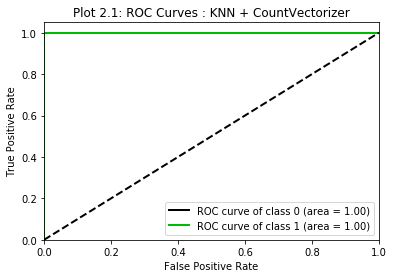

In [29]:
plot_roc(M2,pre2, "Plot 2.1: ROC Curves : KNN + CountVectorizer",X_tr,y_tr, X_te)

roc_auc for class 1: 1.0


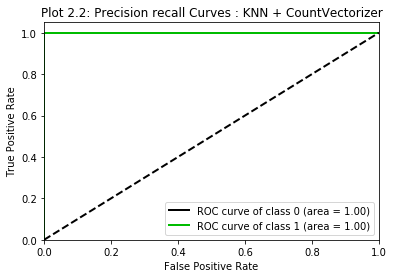

In [30]:
plot_roc(M2,pre2, "Plot 2.2: Precision recall Curves : KNN + CountVectorizer",X_tr,y_tr, X_te)

#### model = M3, TfidfVectorizer(), SVC is linear with c = 2

In [31]:
M3.fit(X_tr2, y_tr2)
pre3 = M3.predict(X_te2)
pd.DataFrame(confusion_matrix(pre3, y_te2),\
             index = ['Predict spam', 'Predict ham'], \
             columns = ['Actual spam', 'Actual ham'])

,Actual spam,Actual ham
Predict spam,128,0
Predict ham,11,976


In [32]:
print(classification_report(pre3, y_te2))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       128
           1       1.00      0.99      0.99       987

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.96      0.99      0.98      1115
weighted avg       0.99      0.99      0.99      1115



roc_auc for class 1: 1.0


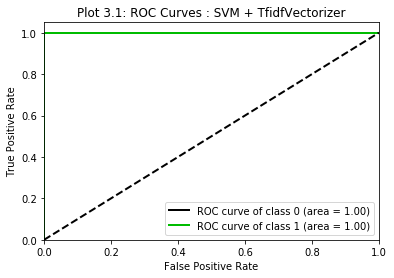

In [33]:
plot_roc(M3,pre3, "Plot 3.1: ROC Curves : SVM + TfidfVectorizer",X_tr2,y_tr2, X_te2)

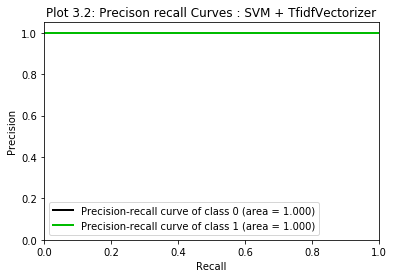

In [35]:
plot_precision(M3,pre3, "Plot 3.2: Precison recall Curves : SVM + TfidfVectorizer",X_tr2,y_tr2, X_te2)

#### model = M4, TfidfVectorizer(), KNN is distance with n = 15

In [36]:
M4.fit(X_tr2, y_tr2)
pre4 = M4.predict(X_te2)
pd.DataFrame(confusion_matrix(pre4, y_te2),\
             index = ['Predict spam', 'Predict ham'], \
             columns = ['Actual spam', 'Actual ham'])

,Actual spam,Actual ham
Predict spam,87,0
Predict ham,52,976


In [37]:
print(classification_report(pre4, y_te2))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        87
           1       1.00      0.95      0.97      1028

   micro avg       0.95      0.95      0.95      1115
   macro avg       0.81      0.97      0.87      1115
weighted avg       0.97      0.95      0.96      1115



roc_auc for class 1: 1.0


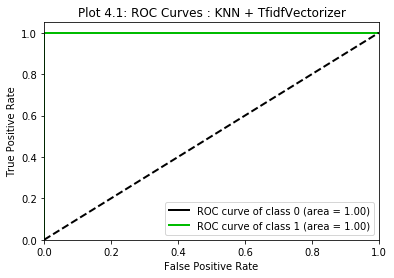

In [38]:
plot_roc(M4,pre4, "Plot 4.1: ROC Curves : KNN + TfidfVectorizer",X_tr2,y_tr2, X_te2)

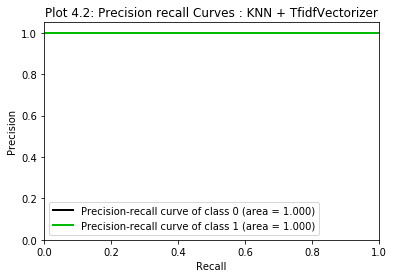

In [39]:
plot_precision(M4,pre4, "Plot 4.2: Precision recall Curves : KNN + TfidfVectorizer",X_tr2,y_tr2, X_te2)